# Processing text queries
- code in this notebook predominantly analyze text queries submitted by participants to solve KIS tasks of VBS 2023
- among others, this notebook can replicate the content of Table 2 and 3 as well as Figures 13-15

In [117]:
import sys
import os
modules_path = os.getcwd() + '/..'
sys.path.insert(0, modules_path)

# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from notebooks.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

pd.set_option('display.max_colwidth', None)
unknownRankLimit = 1000
unknownRankValue = 2000

# Import common data

In [118]:
config = modules_path +'/config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# load the preprocessed query data
dataset = pd.read_pickle(comp_data["config"]["processed_logs_outdir"] + '/text_query_dataset.pkl')

# valid teams
team_order = ['vibro', 'VISIONE',  'vitrivr-VR', 'CVHunter', 'Verge']
#team_order = ['vibro', 'VISIONE', 'VIREO' 'vitrivr-VR', 'CVHunter', 'vitrivr', 'Verge']

dataset.shape

/media/Code/Jupyter/notebook/VBS/VBS Analysis Paper/VBS23_KIS_Analysis/VBS23-Post-Hoc-Analysis/src/python/notebooks/../common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/media/Code/Jupyter/notebook/VBS/VBS Analysis Paper/VBS23_KIS_Analysis/VBS23-Post-Hoc-Analysis/src/python/notebooks/../common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/media/Code/Jupyter/notebook/VBS/VBS Analysis Paper/VBS23_KIS_Analysis/VBS23-Post-Hoc-Analysis/src/python/notebooks/../common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/media/Code/Jupyter/notebook/VBS/VBS Analysis Paper/VBS23_KIS

(784, 20)

### Creating auxiliary variables
- Query length and volume of words per query
- Maybe also store information whether the query is temporal? Only HTW and VISIONE have obviouse temporal queries
- Define visual vs textual tasks

In [141]:
dataset["task_type"] = "visual"
dataset.loc[dataset.task.str.contains("kis-t"),"task_type"] = "textual"

dataset["query_type"] = "Other"
dataset.loc[dataset.is_joint_embedding_text_query, "query_type"] = "CLIP"

dataset["QueryLen"] = -1
dataset["QueryWords"] = -1

dataset.loc[dataset["query_type"]=="CLIP","QueryLen"] = dataset.loc[dataset["query_type"]=="CLIP","value"].str.len()
dataset.loc[dataset["query_type"]=="CLIP","QueryWords"] = dataset.loc[dataset["query_type"]=="CLIP","value"].str.split().str.len()

dataset.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,value,additionals,is_user_with_correct_submission,is_temporal_query,is_joint_embedding_text_query,joint_text_embedding,task_type,query_type,QueryLen,QueryWords
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,Man in pink closest standing a basketball stadium,{},NaN,False,True,"[123, 124, -125, -112, -124, -116, -121, 122, -109, 125, -117, -123, 124, -122, 126, -122, -127, 127, 121, -125, 122, -121, 124, 121, -116, 127, -126, -126, -126, 127, 124, -123, 123, -123, -126, 126, 118, 115, 126, -127, 125, 116, 127, 122, 125, -128, 124, -123, -128, -126, -123, 127, -115, -128, -119, 117, -125, 114, 125, -124, -128, -125, 112, 127, 125, 117, 121, -122, -120, -127, 123, 124, 124, 120, 123, 127, -123, 115, 121, 123, -127, -124, 111, 123, 123, -125, 124, 119, -126, 120, -128, -126, -125, 122, 119, 125, 125, 126, -124, -122, ...]",visual,CLIP,49,8
112,112,112,vbs23-kis-v-m2,vibro,1,1673271280000,29638,45672.0,1.0,4.0,...,video Molok,{},NaN,False,False,None,visual,Other,-1,-1
113,113,113,vbs23-kis-v-m3,vibro,1,1673271639000,15343,24472.0,3.0,6.0,...,black and white dotted snake hiding,{},NaN,False,True,"[-115, -128, 125, 123, 121, -122, 125, -127, -118, 125, 120, 116, 125, 125, 125, 118, 122, -116, -128, 125, 125, -119, -117, -126, 118, 126, -128, -121, -121, -122, 122, -116, -122, 125, -118, 126, 124, 126, 126, 120, 115, -125, -122, -122, 118, -125, 124, 115, -118, -123, 124, 127, 125, 126, -123, -127, 123, 127, -124, -127, 118, -123, 122, -126, 121, 126, 120, -126, 124, -128, -126, -126, 124, 125, 121, 122, -127, -127, 126, 119, -128, -127, 126, 118, -122, -121, 127, 122, -124, 124, -125, 109, 113, 118, -124, 119, 115, -118, 125, 124, ...]",visual,CLIP,36,6
114,114,114,vbs23-kis-v-m4,vibro,1,1673272419000,45815,211429.0,505.0,505.0,...,fishes over corals,{},NaN,False,True,"[124, 126, 121, 121, 121, -119, -127, -128, 118, -125, 127, 124, -128, 124, -124, 126, -127, -123, -124, 126, 124, -125, -127, -127, -124, -128, 126, 123, 126, -125, 116, -119, 124, -125, -127, 121, 117, -117, -125, -127, -127, -128, -124, -123, -126, -126, 126, 116, 127, 121, 122, 124, -123, -123, -127, 119, -117, 124, -127, -127, 125, -115, 125, -126, 121, -125, 127, -124, -127, 127, 127, -127, 120, -128, 118, -118, -126, 126, 124, 122, -118, 125, -126, 118, -125, -128, 126, 122, -122, 124, 127, 121, -119, 120, -121, -125, -123, 127, -125, 127, ...]",visual,CLIP,18,3
115,115,115,vbs23-kis-v-m4,vibro,1,1673272427000,53815,211429.0,393.0,393.0,...,fishes over corals with blue water,{},NaN,False,True,"[121, 126, 119, 122, 123, -120, 127, -128, 115, -126, -127, 124, -127, 121, -120, -127, 124, -121, -128, -127, -125, -121, -125, -128, -122, 123, 124, 124, 121, -127, 117, -123, 125, -124, -126, 123, 115, -119, -122, -126, -127, 127, -128, -121, -125, 126, -128, 121, -127, 123, 124, 127, -123, -127, -124, 117, -116, 124, -127, 125, 126, -115, 121, -125, 120, -122, -128, -124, -127, 125, 124, 125, 122, -126, 116, -115, 126, 118, 122, 121, -119, 123, -124, 116, 127, -125, 125, 122, -123, 121, -126, 122, -117, 113, -121, -125, -116, -127, -120, 127, ...]",visual,CLIP,34,6


# Table 2 in the paper: usage of CLIP queries

In [304]:
# percentage of how many rows per team belong to a text query and an image query
counts = dataset.groupby(["team","query_type"])[["value"]].count()
counts = ((counts / counts.groupby('team')[["value"]].sum())*100).round(1)

# add empty rows
counts = counts.reset_index()
counts = counts.append(pd.DataFrame([{'team': 'vitrivr-VR', 'query_type': 'Other', 'value': 0}], columns=counts.columns))

# sort in team order
counts = counts.set_index(['team','query_type']).loc[team_order, :]
counts

/tmp/ipykernel_10419/3685329919.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts = counts.append(pd.DataFrame([{'team': 'vitrivr-VR', 'query_type': 'Other', 'value': 0}], columns=counts.columns))


value
team       query_type       
vibro      CLIP         52.1
           Other        47.9
VISIONE    CLIP         96.5
           Other         3.5
vitrivr-VR CLIP        100.0
           Other         0.0
CVHunter   CLIP         63.6
           Other        36.4
Verge      CLIP         91.4
           Other         8.6

In [259]:
print(counts.to_latex())

\begin{tabular}{llr}
\toprule
      &       &  value \\
team & query\_type &        \\
\midrule
vibro & CLIP &   52.1 \\
      & Other &   47.9 \\
VISIONE & CLIP &   96.5 \\
      & Other &    3.5 \\
vitrivr-VR & CLIP &  100.0 \\
      & Other &    0.0 \\
CVHunter & CLIP &   63.6 \\
      & Other &   36.4 \\
Verge & CLIP &   91.4 \\
      & Other &    8.6 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10419/1484047370.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(counts.to_latex())


# Table 3

In [390]:
# median values
dataset.loc[dataset.rank_video > unknownRankLimit, "rank_video"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_0 > unknownRankLimit, "rank_shot_margin_0"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_5 > unknownRankLimit, "rank_shot_margin_5"] = unknownRankValue
medianStats = dataset.groupby(["team","user","query_type"])[["rank_shot_margin_0","rank_shot_margin_5","rank_video"]].median()

# mean query length and word count
meanQueryStats = dataset.groupby(["team","user","query_type"])[["QueryWords","QueryLen"]].mean()

# query count per team, user and query_type
queryCount = dataset.groupby(["team", "user", "query_type", "timestamp"])['task'].count().reset_index()
queryCount = queryCount.groupby(["team", "user", "query_type"]).count()
queryCount = queryCount['task']

# construct table
restrData = dataset
top5 = restrData.loc[restrData.rank_shot_margin_0 < 5].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top10 = restrData.loc[restrData.rank_shot_margin_0 < 10].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top20 = restrData.loc[restrData.rank_shot_margin_0 < 20].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top50 = restrData.loc[restrData.rank_shot_margin_0 < 50].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top100 = restrData.loc[restrData.rank_shot_margin_0 < 100].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top200 = restrData.loc[restrData.rank_shot_margin_0 < 200].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top500 = restrData.loc[restrData.rank_shot_margin_0 < 500].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]

resTab1 = pd.DataFrame({"total queries":queryCount,
                        "words / query": 0,
                        "query length": 0,
                        "top5":(top5/queryCount*100).round(1),
                        "top10":(top10/queryCount*100).round(1),
                        "top20":(top20/queryCount*100).round(1),
                        "top50":(top50/queryCount*100).round(1),
                        "top100":(top100/queryCount*100).round(1),
                        "top200":(top200/queryCount*100).round(1),
                        "top500":(top500/queryCount*100).round(1)}).fillna(0)

# in the end we want mean stats
resTab1["words / query"] = meanQueryStats["QueryWords"]
resTab1["query length"] = meanQueryStats["QueryLen"]

# sort in team order
resTab1 = resTab1.loc[team_order, :]
resTab1

total queries  words / query  query length  top5  \
team       user query_type                                                     
vibro      0    CLIP                   38      10.078947     52.447368  10.5   
                Other                  38      -1.000000     -1.000000   2.6   
           1    CLIP                   49       7.163265     38.265306   6.1   
                Other                  42      -1.000000     -1.000000   2.4   
VISIONE    0    CLIP                   50      20.400000    106.040000  10.0   
           1    CLIP                  117      15.076923     76.136752   8.5   
                Other                   5      -1.000000     -1.000000  20.0   
vitrivr-VR 0    CLIP                   38       7.578947     38.342105   5.3   
           1    CLIP                   23       5.086957     26.782609   0.0   
CVHunter   0    CLIP                   76      11.776316     63.881579   3.9   
                Other                  29      -1.000000     -1.000000  10.3   
           1    CLIP                   71       7.000000     40.718310   4.2   
                Other                  55      -1.000000     -1.000000   1.8   
Verge      0    CLIP                  121       5.000000     28.165468   0.8   
                Other                  13      -1.000000     -1.000000   7.7   

                            top10  top20  top50  top100  top200  top500  
team       user query_type                                               
vibro      0    CLIP         13.2   21.1   34.2    39.5    47.4    57.9  
                Other         5.3   13.2   28.9    36.8    39.5    47.4  
           1    CLIP         10.2   18.4   24.5    28.6    32.7    44.9  
                Other         2.4    9.5   19.0    26.2    33.3    59.5  
VISIONE    0    CLIP         10.0   16.0   30.0    38.0    46.0    60.0  
           1    CLIP         11.1   17.1   23.9    29.1    40.2    53.8  
                Other        20.0   20.0   40.0    40.0    60.0    60.0  
vitrivr-VR 0    CLIP         13.2   18.4   21.1    23.7    28.9    28.9  
           1    CLIP          4.3    4.3    4.3     4.3    17.4    17.4  
CVHunter   0    CLIP         17.1   18.4   21.1    27.6    35.5    48.7  
                Other        10.3   10.3   13.8    24.1    34.5    55.2  
           1    CLIP          4.2    5.6    8.5    12.7    23.9    35.2  
                Other         1.8    7.3   12.7    18.2    20.0    30.9  
Verge      0    CLIP          0.8    1.7    3.3     5.0    31.4    39.7  
                Other        15.4   15.4   15.4    23.1    23.1    30.8

## add queries per minute to table 3

In [393]:
# total availabe time to ask queries per team
totTime = dataset.groupby(["team", "task"])[["correct_submission_time_ms"]].min().reset_index().groupby(["team"])["correct_submission_time_ms"].sum()

# query per minute per user, team and query type
queryPerMinute = queryCount/totTime*1000*60
qpmdf = pd.DataFrame({"QPM": queryPerMinute})

# table 3
tab3 = resTab1.reset_index().set_index(['team', 'user', 'query_type'])

# copy queries per minute column for all clip rows
tab3["query / minute"] = qpmdf["QPM"]

# Replace NaN values with zeros
tab3 = tab3.fillna(0)
                   
# Replace -1 with 0
tab3 = tab3.replace(-1, 0)
                   
tab3[["total queries", "query / minute","words / query","query length","top10","top20","top50","top100","top200"]].round(2)

total queries  query / minute  words / query  \
team       user query_type                                                 
vibro      0    CLIP                   38            1.43          10.08   
                Other                  38            1.43           0.00   
           1    CLIP                   49            1.84           7.16   
                Other                  42            1.58           0.00   
VISIONE    0    CLIP                   50            2.02          20.40   
           1    CLIP                  117            4.73          15.08   
                Other                   5            0.20           0.00   
vitrivr-VR 0    CLIP                   38            1.22           7.58   
           1    CLIP                   23            0.74           5.09   
CVHunter   0    CLIP                   76            3.78          11.78   
                Other                  29            1.44           0.00   
           1    CLIP                   71            3.53           7.00   
                Other                  55            2.73           0.00   
Verge      0    CLIP                  121            4.33           5.00   
                Other                  13            0.46           0.00   

                            query length  top10  top20  top50  top100  top200  
team       user query_type                                                     
vibro      0    CLIP               52.45   13.2   21.1   34.2    39.5    47.4  
                Other               0.00    5.3   13.2   28.9    36.8    39.5  
           1    CLIP               38.27   10.2   18.4   24.5    28.6    32.7  
                Other               0.00    2.4    9.5   19.0    26.2    33.3  
VISIONE    0    CLIP              106.04   10.0   16.0   30.0    38.0    46.0  
           1    CLIP               76.14   11.1   17.1   23.9    29.1    40.2  
                Other               0.00   20.0   20.0   40.0    40.0    60.0  
vitrivr-VR 0    CLIP               38.34   13.2   18.4   21.1    23.7    28.9  
           1    CLIP               26.78    4.3    4.3    4.3     4.3    17.4  
CVHunter   0    CLIP               63.88   17.1   18.4   21.1    27.6    35.5  
                Other               0.00   10.3   10.3   13.8    24.1    34.5  
           1    CLIP               40.72    4.2    5.6    8.5    12.7    23.9  
                Other               0.00    1.8    7.3   12.7    18.2    20.0  
Verge      0    CLIP               28.17    0.8    1.7    3.3     5.0    31.4  
                Other               0.00   15.4   15.4   15.4    23.1    23.1

## create empty rows to table 3

In [351]:
from itertools import product

# Get unique values from each column
utab = tab3.reset_index()
unique_teams = utab['team'].unique()
unique_users = utab['user'].unique()
unique_query_types = utab['query_type'].unique()

# Generate all combinations
combinations = product(unique_teams, unique_users, unique_query_types)

# Create a new DataFrame from combinations
new_data = list(combinations)
new_df = pd.DataFrame(new_data, columns=['team', 'user', 'query_type'])
new_df

,team,user,query_type
0,vibro,0,CLIP
1,vibro,0,Other
2,vibro,1,CLIP
3,vibro,1,Other
4,VISIONE,0,CLIP
5,VISIONE,0,Other
6,VISIONE,1,CLIP
7,VISIONE,1,Other
8,vitrivr-VR,0,CLIP
9,vitrivr-VR,0,Other


In [396]:
tab3full = new_df.set_index(['team', 'user', 'query_type'])

# Copy specific columns from df to new_df
columns_to_copy = ["query / minute","words / query","query length","top10","top20","top50","top100","top200"]
tab3full[columns_to_copy] = tab3[columns_to_copy]

# Replace NaN values with zeros
tab3full = tab3full.fillna(0)
                   
# Replace -1 with 0
tab3full = tab3full.replace(-1, 0)           

# round
tab3full = tab3full.round(2)

tab3full

query / minute  words / query  query length  \
team       user query_type                                                
vibro      0    CLIP                  1.43          10.08         52.45   
                Other                 1.43           0.00          0.00   
           1    CLIP                  1.84           7.16         38.27   
                Other                 1.58           0.00          0.00   
VISIONE    0    CLIP                  2.02          20.40        106.04   
                Other                 0.00           0.00          0.00   
           1    CLIP                  4.73          15.08         76.14   
                Other                 0.20           0.00          0.00   
vitrivr-VR 0    CLIP                  1.22           7.58         38.34   
                Other                 0.00           0.00          0.00   
           1    CLIP                  0.74           5.09         26.78   
                Other                 0.00           0.00          0.00   
CVHunter   0    CLIP                  3.78          11.78         63.88   
                Other                 1.44           0.00          0.00   
           1    CLIP                  3.53           7.00         40.72   
                Other                 2.73           0.00          0.00   
Verge      0    CLIP                  4.33           5.00         28.17   
                Other                 0.46           0.00          0.00   
           1    CLIP                  0.00           0.00          0.00   
                Other                 0.00           0.00          0.00   

                            top10  top20  top50  top100  top200  
team       user query_type                                       
vibro      0    CLIP         13.2   21.1   34.2    39.5    47.4  
                Other         5.3   13.2   28.9    36.8    39.5  
           1    CLIP         10.2   18.4   24.5    28.6    32.7  
                Other         2.4    9.5   19.0    26.2    33.3  
VISIONE    0    CLIP         10.0   16.0   30.0    38.0    46.0  
                Other         0.0    0.0    0.0     0.0     0.0  
           1    CLIP         11.1   17.1   23.9    29.1    40.2  
                Other        20.0   20.0   40.0    40.0    60.0  
vitrivr-VR 0    CLIP         13.2   18.4   21.1    23.7    28.9  
                Other         0.0    0.0    0.0     0.0     0.0  
           1    CLIP          4.3    4.3    4.3     4.3    17.4  
                Other         0.0    0.0    0.0     0.0     0.0  
CVHunter   0    CLIP         17.1   18.4   21.1    27.6    35.5  
                Other        10.3   10.3   13.8    24.1    34.5  
           1    CLIP          4.2    5.6    8.5    12.7    23.9  
                Other         1.8    7.3   12.7    18.2    20.0  
Verge      0    CLIP          0.8    1.7    3.3     5.0    31.4  
                Other        15.4   15.4   15.4    23.1    23.1  
           1    CLIP          0.0    0.0    0.0     0.0     0.0  
                Other         0.0    0.0    0.0     0.0     0.0

In [397]:
print(tab3full.to_latex())

\begin{tabular}{lllrrrrrrrr}
\toprule
      &   &       &  query / minute &  words / query &  query length &  top10 &  top20 &  top50 &  top100 &  top200 \\
team & user & query\_type &                 &                &               &        &        &        &         &         \\
\midrule
vibro & 0 & CLIP &            1.43 &          10.08 &         52.45 &   13.2 &   21.1 &   34.2 &    39.5 &    47.4 \\
      &   & Other &            1.43 &           0.00 &          0.00 &    5.3 &   13.2 &   28.9 &    36.8 &    39.5 \\
      & 1 & CLIP &            1.84 &           7.16 &         38.27 &   10.2 &   18.4 &   24.5 &    28.6 &    32.7 \\
      &   & Other &            1.58 &           0.00 &          0.00 &    2.4 &    9.5 &   19.0 &    26.2 &    33.3 \\
VISIONE & 0 & CLIP &            2.02 &          20.40 &        106.04 &   10.0 &   16.0 &   30.0 &    38.0 &    46.0 \\
      &   & Other &            0.00 &           0.00 &          0.00 &    0.0 &    0.0 &    0.0 &     0.0 &     0

/tmp/ipykernel_10419/1364436834.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab3full.to_latex())


# Figure 14

/tmp/ipykernel_10419/1721490895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textData["rankCat"] = ">100"


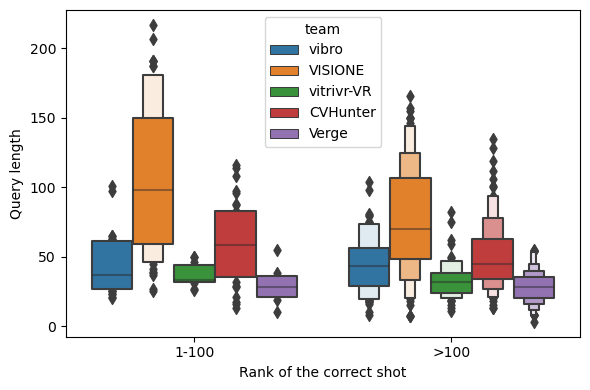

In [407]:
textData = dataset.loc[dataset["query_type"]=="CLIP"]
textData["rankCat"] = ">100"
textData.loc[(textData.rank_shot_margin_0 <= 100),"rankCat"] = "1-100"

fig,ax = plt.subplots(1,1, figsize=(6,4))
textDataWithLength = textData.loc[textData.QueryLen > -1] # just to be sure
hue_order = team_order

#sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax, hue_order = hue_order)
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax, hue_order = hue_order)

#ax.set_xlabel("Rank of the correct shot")
ax.set_xlabel("Rank of the correct shot")
#ax.set_ylabel("Words per query")
ax.set_ylabel("Query length")
plt.tight_layout()
plt.savefig("kis_TextQueryLengthVsRanking.pdf")